# Calculate tomographic bins with a user-defined p(z)

In this example, we will calculate dN/dz in tomographic redshift bins, assuming a photometric redshift pdf that is defined by the user. CCL contains built-in routines that describe the true expected redshift distribution of LSST; the functions used in this example all make use of this built-in data.

**Note:** Some of the function calls in this example are somewhat computationally intensive, and might take a minute or so on a typical laptop.

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
%matplotlib inline

### Define a photo-z pdf
We begin by defining a custom photo-z function, that returns the probabilty of obtaining a given photometric redshift given a particular spectrosopic (true) redshift.

In [2]:
def photoz(z_ph, z_s, args=None):
    """
    Photometric redshift probability, p(z_ph | z_s).
    """
    sigma_z = ccl.sigmaz_sources(z_s)
    return np.exp(- (z_ph - z_s)**2. / (2.*sigma_z**2.)) \
          / (np.sqrt(2.*np.pi) * sigma_z**2.)

The first two arguments of this function must be the photometric redshift and spectroscopic (true) redshift respectively. We could have also specified extra function parameters by using the `args` keyword argument if we wanted to. In this case, we have used a built-in `sigma_z` function, which specifies the default LSST `sigma_z` values (i.e. the effective photo-z accuracy).

We can see what this pdf looks like for a couple of example (true) redshifts:

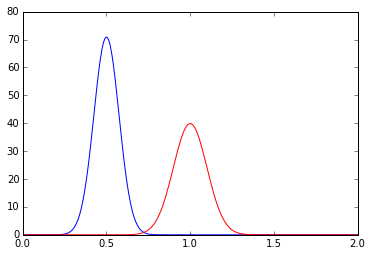

In [3]:
z_ph = np.linspace(0., 2., 200)
plt.plot(z_ph, photoz(z_ph, z_s=0.5), 'b-')
plt.plot(z_ph, photoz(z_ph, z_s=1.0), 'r-')
plt.show()

Now, we must create a new `PhotoZFunction` object to manage the user-defined photo-z pdf. (This allows the function to be called properly by other functions inside CCL, and does some memory management.)

In [4]:
pz = ccl.PhotoZFunction(photoz)

### Calculate the tomographic redshift bin
Now we can calculate dN/dz in a set of tomographic redshift bins, using the `dNdz_tomog` function. This quantity is essentially the true redshft distribution of sources, dN/dz, convolved with a photo-z model, and normalized. First, let's take a look at its call signature:

In [5]:
help(ccl.dNdz_tomog)

Help on function dNdz_tomog in module pyccl.lsst_specs:

dNdz_tomog(z, dNdz_type, zmin, zmax, pz_func)
    Calculates dNdz in a particular tomographic bin, convolved
    with a photo-z model (defined by the user), and normalized.
    
    Args:
        z (float or array_like): Spectroscopic redshifts to evaluate dNdz at.
        dNdz_type (:obj:`str`): Type of redshift distribution.
        zmin (float): Minimum photo-z of the bin.
        zmax (float): Maximum photo-z of the bin.
        pz_func (callable): User-defined photo-z function.
    
    Return:
        dNdz (float or array_like): dNdz values evalued at each z.



As well as a set of redshifts, `z`, to evaluate dN/dz over, we'll also need to pass it the photo-z pdf (`pz_func`, a `PhotoZFunction` object), a minimum and maximum redshift for the bin (`zmin`, `zmax`), and the type of observable that the dN/dz function will be used for, `dNdz_type`. The available types are as follows:

In [6]:
print ccl.lsst_specs.dNdz_types.keys()

['wl_opt', 'nc', 'wl_cons', 'wl_fid']


Here, `nc` stands for 'number counts' and `wl` stands for 'weak lensing'. We'll use the fiducial weak lensing type, `wl_fid` (the others are 'conservative' and 'optimistic', describing pessimistic and optimistic scenarios for how many galaxies will be detected that are suitable for a weak lensing analysis).

We can then call `dNdz_tomog` to get the number counts in a bin like so:

In [7]:
z = np.linspace(0., 2., 100)
dNdz = ccl.dNdz_tomog(z, 'wl_fid', 0.1, 0.7, pz)

Note that this can take a little while to calculate. This is slower than in the C version of CCL because the photo-z function is called many times by an integration routine inside the library. Calling a Python function, in this case `photoz()`, is slower than calling an internal C function.

We can now plot the results:

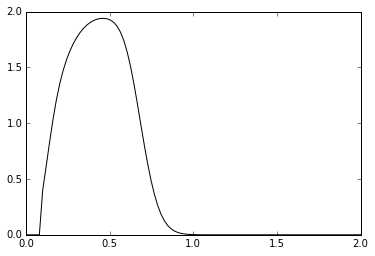

In [8]:
plt.plot(z, dNdz, 'k-')
plt.show()

For the sake of completeness, let's also try a few other redshift bin bounds, more in line with how the LSST bins will be defined:

In [9]:
dNdz1 = ccl.dNdz_tomog(z, 'wl_fid', 0., 0.6, pz)

In [10]:
dNdz2 = ccl.dNdz_tomog(z, 'wl_fid', 0.6, 1.2, pz)

In [11]:
dNdz3 = ccl.dNdz_tomog(z, 'wl_fid', 1.2, 1.8, pz)

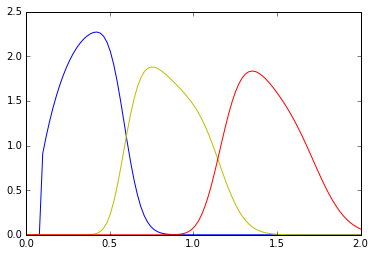

In [12]:
plt.plot(z, dNdz1, 'b-')
plt.plot(z, dNdz2, 'y-')
plt.plot(z, dNdz3, 'r-')
plt.show()

### Effective dN/dz for different types of observable
LSST will obtain different galaxy number counts for different types of observable, depending on what the galaxies will be used for. For example, not all detected galaxies will be suitable for weak lensing. The `dNdz_type` argument specifies which _intrinsic_ dN/dz distribution should be used to calculate the observed photometric redshift distribution. Let's compare the various options from above:

In [13]:
dNdz_wlfid = ccl.dNdz_tomog(z, 'wl_fid', 0.6, 1.2, pz)

In [14]:
dNdz_wlcons = ccl.dNdz_tomog(z, 'wl_cons', 0.6, 1.2, pz)

In [15]:
dNdz_wlopt = ccl.dNdz_tomog(z, 'wl_opt', 0.6, 1.2, pz)

In [16]:
dNdz_nc = ccl.dNdz_tomog(z, 'nc', 0.6, 1.2, pz)

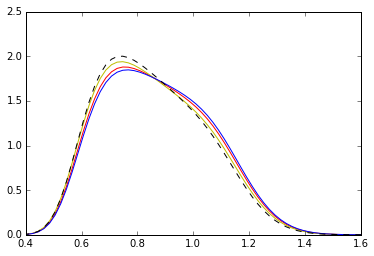

In [17]:
plt.plot(z, dNdz_wlfid, 'r-')
plt.plot(z, dNdz_wlcons, 'y-')
plt.plot(z, dNdz_wlopt, 'b-')
plt.plot(z, dNdz_nc, 'k--')
plt.xlim((0.4, 1.6))
plt.show()

Recall that these functions have all been normalised. As such, dN/dz in the optimistic weak lensing case (which assumes that more galaxies suitable for weak lensing will be detected) is not above the conservative curve everywhere in this plot, as it would be if left unnormalised. Notice that it has a heavier tail at high redshift, though.